<a href="https://colab.research.google.com/github/Biline-dev/AI_tools/blob/main/Audio_Sentiment_Analysis_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Presented by :
  * Boulmaali Linda Imene

#Build an Audio Sentiement Analysis model using Tenserflow and Scikit learn


Audio Sentiment Analysis involves detecting the emotional tone or sentiment (e.g., positive, negative, neutral) from audio recordings. This task combines aspects of speech processing, feature extraction, and machine learning. By leveraging tools like **TensorFlow** for deep learning and **Scikit-learn** for classical machine learning techniques, we can build a robust pipeline to analyze sentiment from audio data.

## Key Steps:

* **Data Analysis**:
   - Explore the dataset to understand its structure and distribution.
   - Visualize audio features like waveforms, spectrograms, or MFCCs to gain insights.
   - Check for data imbalances and outliers that may affect model performance.

* **Preprocessing**:
   Convert raw audio signals into meaningful features:
   - **Mel-frequency cepstral coefficients (MFCCs)**: Capture the spectral properties of audio.
   - **Spectrograms**: Represent the frequency spectrum over time for visual feature extraction.

* **Modeling**:
   - Use **TensorFlow** to build deep learning architectures (e.g., CNNs or LSTMs) that can capture complex patterns in audio features.
   - Employ **Scikit-learn** for classical models like Random Forests or SVMs, which work well with lower-dimensional features.



Install some packages

In [ ]:
!pip install pydub librosa soundfile
!pip install ipython librosa
!pip install datasets
!pip install evaluate

Connect to google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import tensorflow as tf
device_list = tf.test.gpu_device_name()
device_list

Mounted at /content/drive


''

# Util functions

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc
)
import tensorflow as tf

class Benchmark:
    def __init__(self, models, histories=None, models_name=None):
        """
        Initialize the Benchmark class.

        Args:
            models: List of trained models.
            histories: List of training history objects corresponding to each model (optional).
        """
        self.models = models
        self.histories = histories
        self.metrics = []

    def predict_classes(self, X_tests, y_test):
        """
        Generate predictions and predicted classes for each model.
        Stores y_pred and y_pred_classes for each model.

        Args:
            X_tests: List of test datasets matching the input format for each model.
            y_test: Ground truth labels for the test set.
        """
        self.y_preds = []
        self.y_pred_classes = []
        self.class_reports = []

        for i, model in enumerate(self.models):
            y_pred = model.predict(X_tests)
            y_pred_classes = np.argmax(y_pred, axis=-1)


            self.y_preds.append(y_pred)
            self.y_pred_classes.append(y_pred_classes)

            # Calculate evaluation metrics for the model
            accuracy = accuracy_score(y_test, y_pred_classes)
            precision = precision_score(y_test, y_pred_classes, average='weighted')
            recall = recall_score(y_test, y_pred_classes, average='weighted')
            f1 = f1_score(y_test, y_pred_classes, average='weighted')

            self.metrics.append({
                'Model': f'Model_{models_name[i]}',
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1
            })

            # Add classification report for this model
            report = classification_report(y_test, y_pred_classes, output_dict=True)
            self.class_reports.append(report)

    def plot_confusion_matrices(self, y_test):
        """
        Plot confusion matrices for each model in subplots.

        Args:
            y_test: Ground truth labels for the test set.
        """
        num_models = len(self.models)
        plt.figure(figsize=(10, 3 * num_models))

        for i, y_pred_classes in enumerate(self.y_pred_classes):
            cm = confusion_matrix(y_test, y_pred_classes)
            plt.subplot(num_models, 1, i + 1)
            sns.heatmap(
                cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y_test),
                yticklabels=np.unique(y_test)
            )
            plt.title(f"Confusion Matrix for Model_{models_name[i]}")
            plt.xlabel("Predicted")
            plt.ylabel("True")

        plt.tight_layout()
        plt.show()

    def plot_roc_curves(self, y_test):
        """
        Plot ROC curves for all models in subplots.

        Args:
            y_test: Ground truth labels for the test set.
        """
        y_test_binary = tf.keras.utils.to_categorical(y_test, num_classes=self.y_preds[0].shape[-1])
        num_models = len(self.models)
        plt.figure(figsize=(10, 3 * num_models))

        for i, y_pred in enumerate(self.y_preds):
            plt.subplot(num_models, 1, i + 1)
            for j in range(y_pred.shape[-1]):
                fpr, tpr, _ = roc_curve(y_test_binary[:, j], y_pred[:, j])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f"Class {j} (AUC = {roc_auc:.2f})")
            plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
            plt.title(f"ROC Curve for Model_{models_name[i]}")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.legend(loc="lower right")

        plt.tight_layout()
        plt.show()

    def plot_training_histories(self):
        """
        Plot training and validation metrics for all models in separate subplots.
        """
        if not self.histories:
            print("No training histories provided.")
            return

        num_models = len(self.histories)
        plt.figure(figsize=(10, 3 * num_models))

        for i, history in enumerate(self.histories):
            # Plot Loss
            plt.subplot(num_models, 2, 2 * i + 1)
            plt.plot(history.history['loss'], label='Train Loss')
            if 'val_loss' in history.history:
                plt.plot(history.history['val_loss'], label='Validation Loss')
            plt.title(f"Loss for Model_{models_name[i]}")
            plt.ylabel("Loss")
            plt.xlabel("Epoch")
            plt.legend()

            # Plot Accuracy
            plt.subplot(num_models, 2, 2 * i + 2)
            plt.plot(history.history['accuracy'], label='Train Accuracy')
            if 'val_accuracy' in history.history:
                plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
            plt.title(f"Accuracy for Model_{models_name[i]}")
            plt.ylabel("Accuracy")
            plt.xlabel("Epoch")
            plt.legend()

        plt.tight_layout()
        plt.show()

    def get_metrics_dataframe(self):
        """
        Create a DataFrame summarizing evaluation metrics for all models.

        Returns:
            DataFrame containing evaluation metrics for all models.
        """
        return pd.DataFrame(self.metrics)

    def print_classification_reports(self):
        """
        Print classification reports for each model.
        """
        for i, report in enumerate(self.class_reports):
            print(f"Classification Report for Model_{models_name[i]}:")
            print(pd.DataFrame(report).transpose())
            print("\n")


# Data Preparation

About Dataset

The dataset consists of audio files with different emotions that can be categorized into 3 classess:-

  * Positive
  * Negative
  * Neutral

The dataset :

  * "TRAIN" directory (contains .wav files for training)
  * TRAIN.csv contains filenames and classes

link: https://www.kaggle.com/datasets/imsparsh/audio-speech-sentiment/data

In [3]:
data_path = "/content/drive/My Drive/Master2_Paris8/AI_tool/projet/data/"

In [4]:
from IPython.display import Audio
import librosa

# Load the audio file
file_path = data_path + "TRAIN/9.wav"for
y, sr = librosa.load(file_path, sr=None) # librosa.load() reads the audio file located at file_path and returns two key pieces of information:
"""
y (Audio Data):

    A 1D NumPy array (if the audio is mono) or a 2D array (if the audio is stereo).
    It contains the amplitude values of the audio signal, normalized to the range [-1.0, 1.0].

sr (Sampling Rate):

    The number of audio samples per second (e.g., 22050 Hz or 44.1 kHz).
    This is essential for processing tasks like resampling or feature extraction.
"""

# Display and play the audio
Audio(data=y, rate=sr)


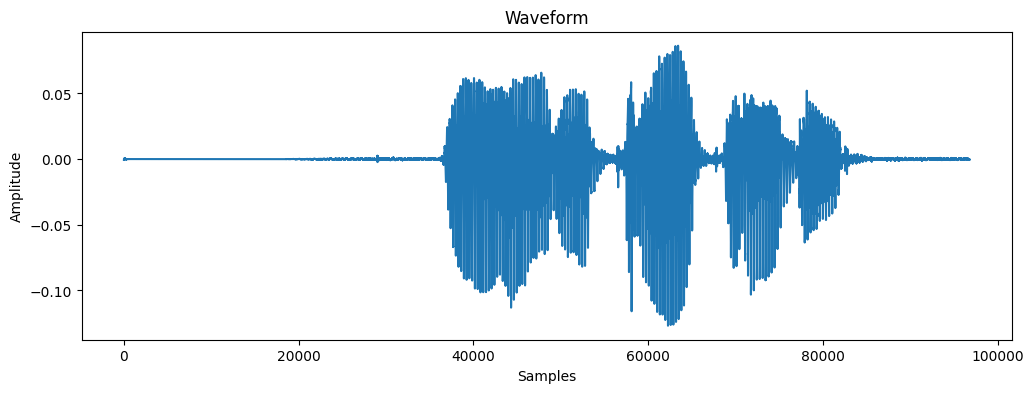

In [5]:
import matplotlib.pyplot as plt

# Plot the waveform
plt.figure(figsize=(12, 4))
plt.plot(y)
plt.title("Waveform")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()


This is an example of one sample data

# Data Analysis

#### File Count

In [6]:
import os

train_folder = data_path + "TRAIN"
train_files = [f for f in os.listdir(train_folder) if f.endswith('.wav')]
print(f"Number of train files: {len(train_files)}")

Number of train files: 250


#### Audio Duration Analysis

In [7]:
import librosa
import numpy as np

def get_audio_duration(file_path):
    y, sr = librosa.load(file_path, sr=None)
    return len(y) / sr

train_durations = [get_audio_duration(os.path.join(train_folder, f)) for f in train_files]
print(f"Train durations: {np.min(train_durations)} to {np.max(train_durations)} seconds")

Train durations: 1.6979591836734693 to 3.944489795918367 seconds


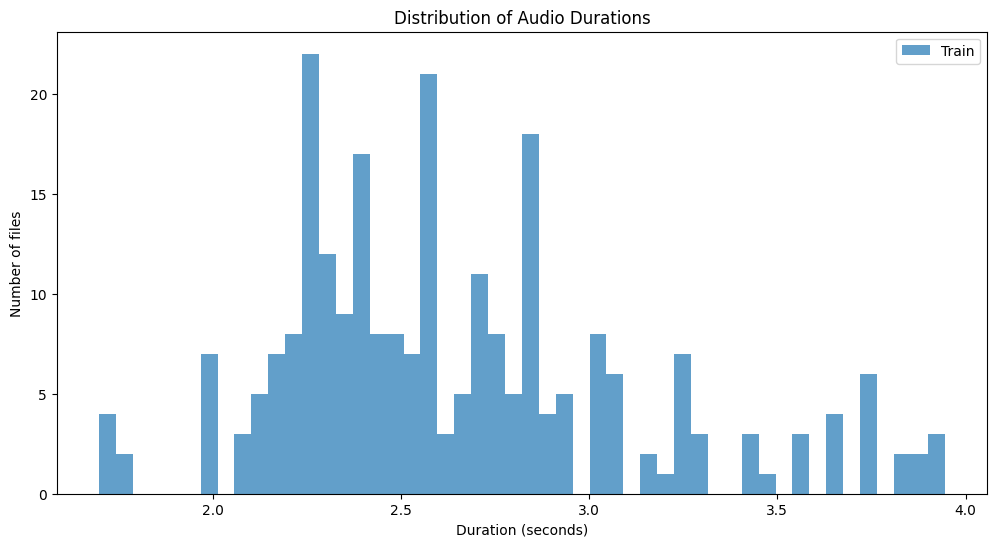

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.hist(train_durations, bins=50, alpha=0.7, label='Train')
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of files")
plt.title("Distribution of Audio Durations")
plt.legend()
plt.show()


There is a variation in the distribution of durations in the training files.

#### Sampling Rate Analysis

In [9]:
"""
  - Ensure all audio files have a consistent sampling rate.
  - Identify any discrepancies or outliers.
"""
def get_sampling_rate(file_path):
    _, sr = librosa.load(file_path, sr=None)
    return sr

train_sampling_rates = [get_sampling_rate(os.path.join(train_folder, f)) for f in train_files]
print(f"Unique sampling rates in Train: {set(train_sampling_rates)}")

Unique sampling rates in Train: {44100}


#### Audio Amplitude/Signal Analysis

In [10]:
"""Check the amplitude range of audio files to spot files with very low or silent audio."""
def get_amplitude_stats(file_path):
    y, _ = librosa.load(file_path, sr=None)
    return np.mean(np.abs(y)), np.max(np.abs(y))

train_amplitudes = [get_amplitude_stats(os.path.join(train_folder, f)) for f in train_files]

# Separate mean and max amplitudes for plotting
train_mean_amp, train_max_amp = zip(*train_amplitudes)

print(f"Train mean amplitude range: {np.min(train_mean_amp)} to {np.max(train_mean_amp)}")

Train mean amplitude range: 0.007590708322823048 to 2347.43603515625


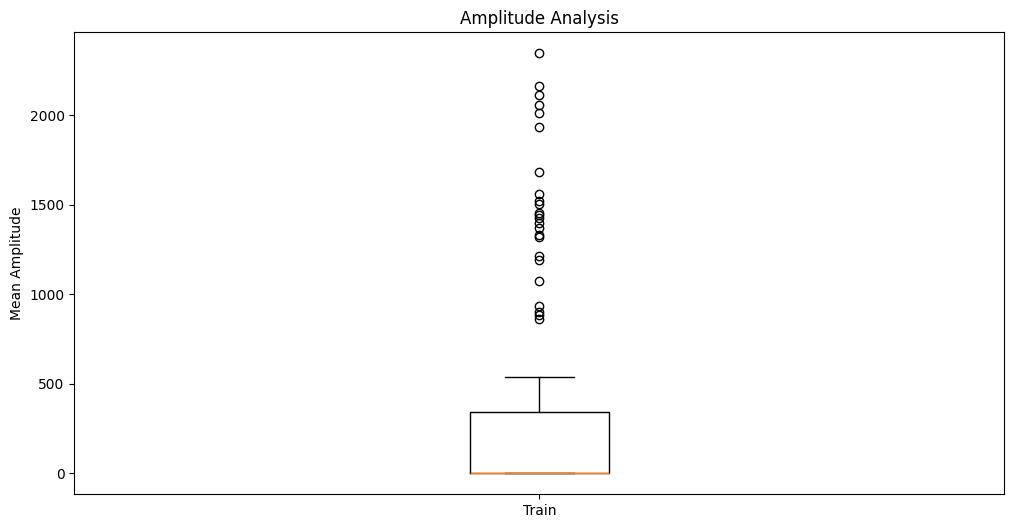

In [11]:
plt.figure(figsize=(12, 6))
plt.boxplot([train_mean_amp], labels=['Train'])
plt.ylabel("Mean Amplitude")
plt.title("Amplitude Analysis")
plt.show()


The data is heavily right-skewed due to the presence of a large number of high outliers.

Noise in the data: Some training examples or features have abnormally high amplitudes.

####  Silence and Noise Analysis

In [12]:
"""
- Identify files with large silent portions or background noise.
- Measure silence as a proportion of the total duration.
"""
def calculate_silence_ratio(file_path, threshold=0.01):
    y, _ = librosa.load(file_path, sr=None)
    silence = np.sum(np.abs(y) < threshold)
    return silence / len(y)

train_silence_ratios = [calculate_silence_ratio(os.path.join(train_folder, f)) for f in train_files]
print(f"Train silence ratio range: {np.min(train_silence_ratios)} to {np.max(train_silence_ratios)}")

Train silence ratio range: 0.09777984731420161 to 0.8000578703703703


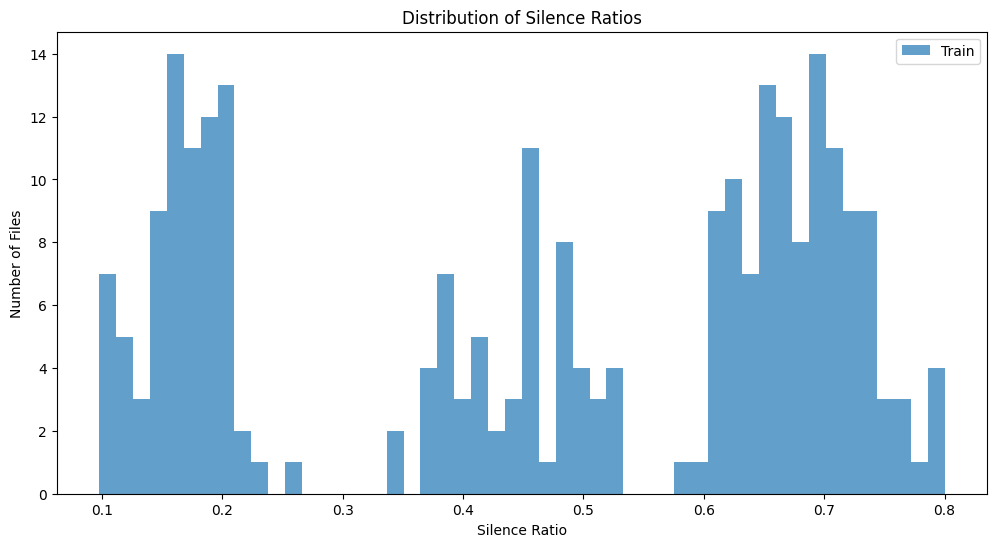

In [13]:
plt.figure(figsize=(12, 6))
plt.hist(train_silence_ratios, bins=50, alpha=0.7, label='Train')
plt.xlabel("Silence Ratio")
plt.ylabel("Number of Files")
plt.title("Distribution of Silence Ratios")
plt.legend()
plt.show()


There are three prominent clusters:

  * Files with silence ratios around 0.2 (20%).
  * Files with silence ratios around 0.5 (50%).
  * Files with silence ratios around 0.7 (70%).
  
This suggests that the dataset contains a mix of audio files with varying amounts of silence, possibly due to differences in recording styles or content types

#### Frequency Content Analysis

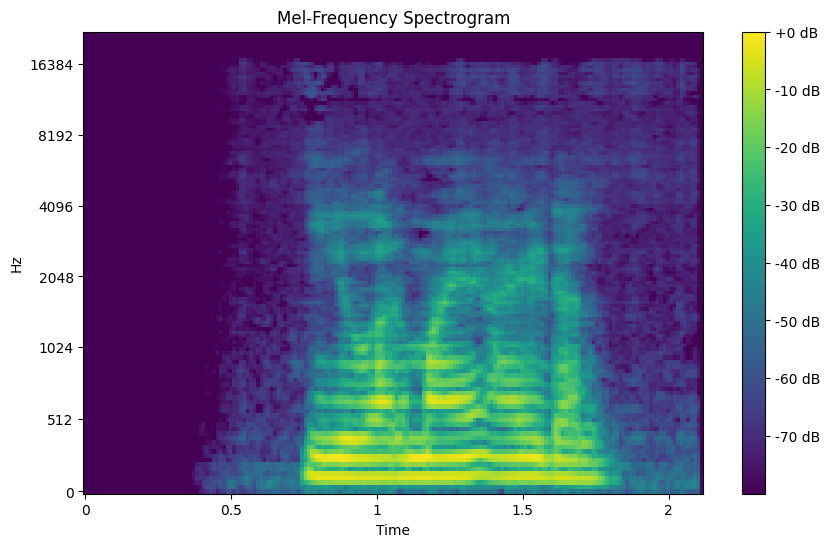

In [14]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

"""

A spectrogram is a visual representation of the frequency content of a signal over time.
What It Shows:

    The x-axis represents time.
    The y-axis represents frequency.
    The color intensity (or brightness) shows the amplitude (strength) of a frequency at a specific time.

Why Use a Spectrogram?

    To visualize changes in pitch, tone, or harmonics over time.

"""
def plot_spectrogram(file_path):
    # Load the audio file
    y, sr = librosa.load(file_path, sr=None)

    # Compute the mel spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=sr//2)

    # Convert to decibels for visualization
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Plot the spectrogram
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-Frequency Spectrogram')
    plt.show()

# Example: Visualize a spectrogram for a train file
plot_spectrogram(os.path.join(train_folder, train_files[0]))


These spectogram can be used to train models based on these images.

#### Label/Metadata Analysis

In [15]:
import pandas as pd

# Example: Load metadata CSV containing filenames and labels
metadata = pd.read_csv(data_path+'TRAIN.csv')
print(metadata['Class'].value_counts())


Class
Negative    87
Positive    82
Neutral     81
Name: count, dtype: int64


# Data Processing

In these steps we're going to pre process the data

In [16]:
import librosa
import numpy as np


def load_audio(file_path, target_sr=16000):
    """Loads an audio file and resamples it to the target sampling rate."""
    y, sr = librosa.load(file_path, sr=target_sr)  # Resample to 16 kHz
    return y, sr

def resample_audio(y, orig_sr, target_sr=16000):
    """
      Resample audio signal to the target sampling rate.
      Handles cases where the original sampling rate differs from the one needed for uniformity.
    """
    y_resampled = librosa.resample(y, orig_sr=orig_sr, target_sr=target_sr)
    return y_resampled
def trim_silence(y, top_db=20):
    """
      Trim leading and trailing silence from the audio.
      Removes leading and trailing silence from the audio.
    """
    y_trimmed, _ = librosa.effects.trim(y, top_db=top_db)
    return y_trimmed


def standardize_duration(y, sr, fixed_duration=3.0):
    """Pad or truncate audio to a fixed duration in seconds."""
    target_length = int(fixed_duration * sr)
    if len(y) < target_length:
        # Pad with zeros if the audio is too short
        y = np.pad(y, (0, target_length - len(y)))
    else:
        # Truncate if the audio is too long
        y = y[:target_length]
    return y

def normalize_audio(y):
    """Normalize the audio signal to the range [-1, 1]."""
    return y / np.max(np.abs(y))


def preprocess_audio(file_path, target_sr=16000, fixed_duration=3.0):
    """Preprocess an audio file: resample, mono conversion, trim, standardize, and normalize."""
    # Load audio
    y, sr = load_audio(file_path, target_sr=target_sr)

    # Trim silence
    y = trim_silence(y)

    # Standardize duration
    y = standardize_duration(y, sr=target_sr, fixed_duration=fixed_duration)

    # Normalize audio
    y = normalize_audio(y)

    return y, target_sr


In [17]:
import os

def preprocess_dataset(folder_path, target_sr=16000, fixed_duration=3.0):
    """Preprocess all audio files in a folder."""
    processed_data = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.wav'):
            file_path = os.path.join(folder_path, file_name)
            y, sr = preprocess_audio(file_path, target_sr=target_sr, fixed_duration=fixed_duration)
            processed_data.append((file_name, y, sr))
    return processed_data

# Preprocess train and test datasets
train_processed = preprocess_dataset(data_path+'TRAIN')

In [18]:
len(train_processed[0][1])

48000

In [19]:
import soundfile as sf

def save_preprocessed_audio(output_folder, processed_data):
    """Save preprocessed audio to a folder."""
    os.makedirs(output_folder, exist_ok=True)
    for file_name, y, sr in processed_data:
        output_path = os.path.join(output_folder, file_name)
        sf.write(output_path, y, sr)

# Save preprocessed train and test datasets
save_preprocessed_audio(data_path+"preprocessed_train", train_processed)

MFCC (
Mel-frequency cepstrum
)

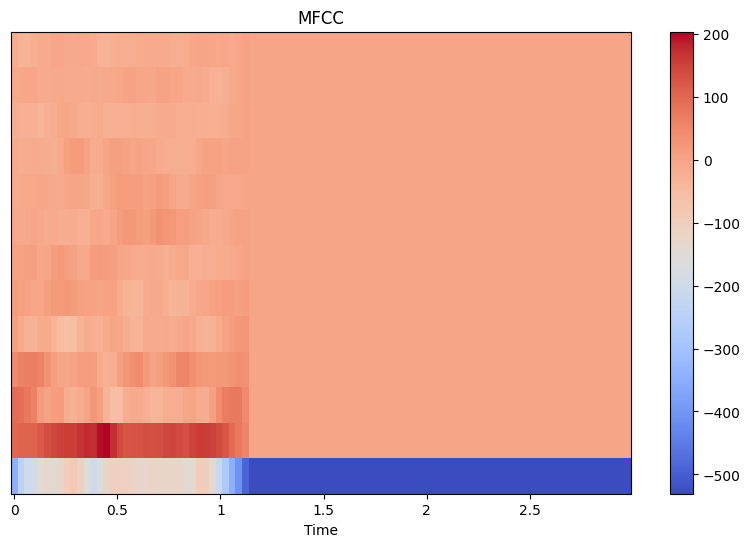

In [20]:
"""
MFCCs are crucial for audio analysis as they condense spectral and perceptual features of sound into a compact,
human-like representation, making them ideal for tasks like speech and emotion recognition.
"""
def extract_mfcc(y, sr, n_mfcc=13):
    """Extract MFCC features from an audio signal."""
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfccs

# Example: Extract MFCCs from the first file in the processed train data
y, sr = train_processed[0][1], train_processed[0][2]
mfccs = extract_mfcc(y, sr)

# Visualize the MFCCs
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(10, 6))
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar()
plt.title('MFCC')
plt.show()


Spectrogram

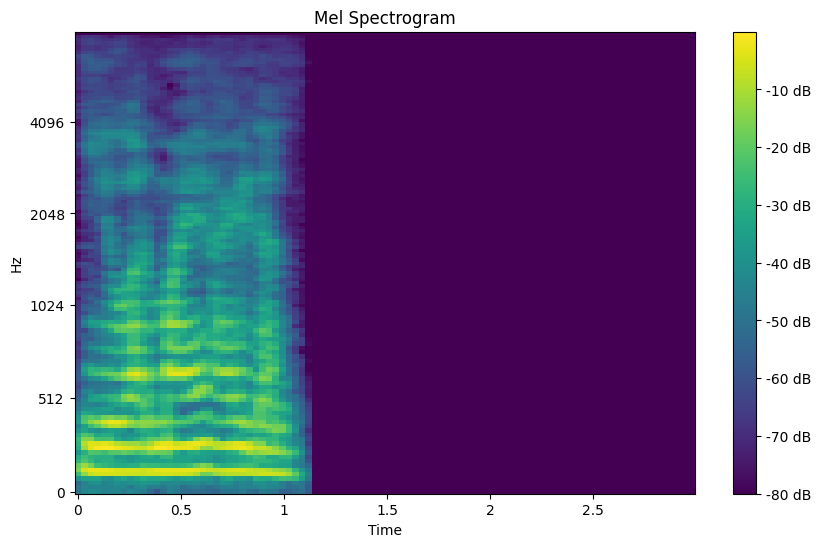

In [21]:
def extract_spectrogram(y, sr):
    """Extract spectrogram features."""
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=sr//2)
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB

# Example: Extract and visualize spectrogram
spectrogram = extract_spectrogram(y, sr)

plt.figure(figsize=(10, 6))
librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()


When to spectogram or MFCC?

  * Use Mel Spectrogram when:
      * For detailed frequency analysis.
      Working with music, environmental sounds, or audio classification tasks.
      * Visualizing how energy changes over time.

  * Use MFCC when:
      * Compact and efficient representation of sound.
      * Working with tasks like speech recognition or emotion analysis, where vocal tract information matters.
      * Prioritizing computational efficiency.

# Modelisation

#### Prepare functions

In [24]:
def extract_features(data, feature_type='spectrogram', n_mfcc=13):
    """Extract features (MFCC or spectrogram) for all audio data."""
    features = []
    for file_name, y, sr in data:
        if feature_type == 'mfcc':
            feature = extract_mfcc(y, sr, n_mfcc=n_mfcc)
        elif feature_type == 'spectrogram':
            feature = extract_spectrogram(y, sr)
        features.append((file_name, feature))
    return features



In [25]:
import numpy as np

def pad_or_truncate_features(features, target_timesteps):
    """Pad or truncate feature matrices to ensure uniform length."""
    processed_features = []
    for _, feature in features:
        if feature.shape[1] < target_timesteps:  # Pad
            padding = target_timesteps - feature.shape[1]
            feature = np.pad(feature, ((0, 0), (0, padding)), mode='constant')
        else:  # Truncate
            feature = feature[:, :target_timesteps]
        processed_features.append(feature.T)  # Transpose to (timesteps, features)
    return np.array(processed_features)


In [26]:
def flatten_features(features):
    """Flatten the 2D feature arrays into 1D vectors."""
    X = []
    for file_name, feature in features:
        # Flatten the feature matrix to 1D vector (time_steps * n_features)
        flattened_feature = feature.flatten()
        X.append(flattened_feature)
    return np.array(X)

In [27]:
def normalize_features(X):
    """Normalize the features using StandardScaler."""
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)  # Fit on X and transform to standardize
    return X_normalized

#### prepare data for modelisation

In [63]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Save preprocessed train and test datasets
save_preprocessed_audio(data_path+"preprocessed_train", train_processed)
# Extract features for train and test datasets
train_features = extract_features(train_processed, feature_type='mfcc')

# Match features to labels
labels_dict = dict(zip(metadata['Filename'], metadata['Class']))
y_train = [labels_dict[file_name] for file_name, _ in train_features]

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# After encoding labels
label_mapping = dict(enumerate(label_encoder.classes_))

print("Label to Class Mapping:")
for label, class_name in label_mapping.items():
    print(f"{label}: {class_name}")


Label to Class Mapping:
0: Negative
1: Neutral
2: Positive


In [69]:
# Preprocess train and test datasets
train_processed = preprocess_dataset(data_path+'TRAIN')
# Extract features for train and test datasets
train_features = extract_features(train_processed, feature_type='mfcc')

# Flatten the features to prepare for machine learning models
X = flatten_features(train_features)

# Normalize the features
X_normalized = normalize_features(X)


# Split data
from sklearn.model_selection import train_test_split

# You should have your normalized and preprocessed X_train, y_train, X_val, and y_val as per your previous code
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_normalized, y_train_encoded, test_size=0.2, random_state=42)

## Machine learning models

In [70]:
X_train, X_test, y_train, y_test = X_train_, X_test_, y_train_, y_test_

In [30]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define models
models = {
    'RandomForest': RandomForestClassifier(),
    'SVM': SVC(),
    'LogisticRegression': LogisticRegression(),
    'KNeighbors': KNeighborsClassifier()
}

# Define hyperparameter grids for each model
param_grid = {
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    'LogisticRegression': {
        'C': [0.1, 1, 10],
        'solver': ['liblinear', 'lbfgs']
    },
    'KNeighbors': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
}

# Prepare a DataFrame to store results
results = []

# Iterate through models and perform Grid SearchAPPARTEMENT 601APPARTEMENT 601
for model_name, model in models.items():
    print(f"Running Grid Search for {model_name}...")

    # Set up GridSearchCV
    grid_search = GridSearchCV(model, param_grid[model_name], cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

    # Fit GridSearchCV
    grid_search.fit(X_train.reshape(X_train.shape[0], -1), y_train)  # Reshaping if needed

    # Get the best model
    best_model = grid_search.best_estimator_

    # Evaluate on the test set
    y_pred = best_model.predict(X_test.reshape(X_test.shape[0], -1))  # Reshaping if needed

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # Store results
    results.append({
        'Model': model_name,
        'Best Params': grid_search.best_params_,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

    print(f"Best Params for {model_name}: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}\n")

# Convert results to DataFrame
results_df = pd.DataFrame(results)



Running Grid Search for RandomForest...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Params for RandomForest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.96, Precision: 0.9642105263157894, Recall: 0.96, F1 Score: 0.96

Running Grid Search for SVM...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Params for SVM: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy: 0.98, Precision: 0.9811111111111112, Recall: 0.98, F1 Score: 0.9800154440154439

Running Grid Search for LogisticRegression...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Params for LogisticRegression: {'C': 1, 'solver': 'liblinear'}
Accuracy: 0.98, Precision: 0.9811111111111112, Recall: 0.98, F1 Score: 0.9800154440154439

Running Grid Search for KNeighbors...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Params for KNeighbors: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distanc

In [31]:
results_df

,Model,Best Params,Accuracy,Precision,Recall,F1 Score
0,RandomForest,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_...",0.96,0.964211,0.96,0.960000
1,SVM,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}",0.98,0.981111,0.98,0.980015
2,LogisticRegression,"{'C': 1, 'solver': 'liblinear'}",0.98,0.981111,0.98,0.980015
3,KNeighbors,"{'metric': 'manhattan', 'n_neighbors': 3, 'wei...",0.96,0.964211,0.96,0.960000


### Evaluation

In [32]:
# Print classification report
print(f"Classification Report for the Best Model ({best_model}):")
print(classification_report(y_test, y_pred))


Classification Report for the Best Model (KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')):
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        19
           1       1.00      1.00      1.00        14
           2       0.89      1.00      0.94        17

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50



## Deep learning models

### With feature_type='mfcc'

#### CNN

In [128]:
X_train, X_test, y_train, y_test = X_train_, X_test_, y_train_, y_test_

In [129]:
X_train= X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  # Shape: (samples, chanel, features)
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))  # Shape: (samples, chanel, features)
X_train.shape

(200, 1, 1222)

In [92]:
def create_and_train_cnn_model(input_shapes, num_classes, batch_size = 200,
                               dropout_rate=0.5, X_train=None, y_train=None, kernel_regularizer=tf.keras.regularizers.l2(0.001),
                               optimizer='adam', metrics=['accuracy'], validation_split=0.2, epochs=20, early_stopping = None):
    inputs = [tf.keras.Input(shape=shape) for shape in input_shapes]

    # Define dense layer configurations
    dense_layers_config = [
        {'units': 100, 'activation': 'relu'},
        {'units': 50, 'activation': 'relu'}
    ]

    # Define convolutional layer configurations for the CNN model
    conv_layers_config = [
        {'filters': 32, 'kernel_size': 3, 'activation': 'relu', 'pool_size': 3},
        {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'pool_size': 3}
    ]
    # Apply convolutional layers to each input
    processed_inputs = []
    for input_tensor in inputs:
        x = input_tensor
        for layer_config in conv_layers_config:
            x = tf.keras.layers.Conv1D(
                filters=layer_config['filters'],
                kernel_size=layer_config['kernel_size'],
                activation=layer_config.get('activation', 'relu'),
                kernel_regularizer=kernel_regularizer,
                padding='same'
            )(x)

            if x.shape[1] > 1 and 'pool_size' in layer_config:
                x = tf.keras.layers.MaxPooling1D(pool_size=layer_config['pool_size'])(x)
            x = tf.keras.layers.Dropout(dropout_rate)(x)

        processed_inputs.append(tf.keras.layers.Flatten()(x))

    # Concatenate flattened outputs
    x = tf.keras.layers.concatenate(processed_inputs, axis=-1)

    # Dense layers
    for layer_config in dense_layers_config:
        x = tf.keras.layers.Dense(
            units=layer_config['units'],
            activation=layer_config.get('activation', 'relu'),
            kernel_regularizer=kernel_regularizer
        )(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)

    output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=output)

    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=metrics)
    model.summary()

    # Train the model if training data is provided
    if X_train and y_train is not None:
        history = model.fit(
            x=X_train, y=y_train,
            validation_split=validation_split,
            epochs=epochs,
            batch_size = 200
        )
        return model, history
    else:
        return model, None


In [93]:
from tensorflow.keras.callbacks import EarlyStopping

# Define input shapes for the four inputs
input_shapes = [(1, X_train[0].shape[1])]

# Number of classes for the output
num_classes = len(np.unique(y_train))

# Create the CNN model
model_cnn, history_cnn = create_and_train_cnn_model(
    input_shapes=input_shapes,
    num_classes=num_classes,
    dropout_rate=0.3,
    optimizer='adam',
    metrics=['accuracy'],
    validation_split=0.2,
    X_train=[X_train],
    y_train=y_train,
    epochs=10,
    early_stopping=EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 1, 1222)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 1, 32)               │         117,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 1, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 1, 64)               │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ concatenate_8 (Concatenate)          │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 100)                 │           6,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 3)                   │             153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 135,255 (528.34 KB)

 Trainable params: 135,255 (528.34 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3688 - loss: 1.3253 - val_accuracy: 0.4750 - val_loss: 1.3071
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4187 - loss: 1.3127 - val_accuracy: 0.5000 - val_loss: 1.2494
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4563 - loss: 1.2507 - val_accuracy: 0.5500 - val_loss: 1.1925
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5250 - loss: 1.2036 - val_accuracy: 0.6250 - val_loss: 1.1412
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4875 - loss: 1.1728 - val_accuracy: 0.6500 - val_loss: 1.0954
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5938 - loss: 1.0994 - val_accuracy: 0.7000 - val_loss: 1.0572
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6000 - loss: 1.0731 - val_accuracy: 0.7250 - val_loss: 1.0252
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.6562 - loss: 1.0126 - val_accuracy: 0.7500 - val_loss: 0.9960
Ep

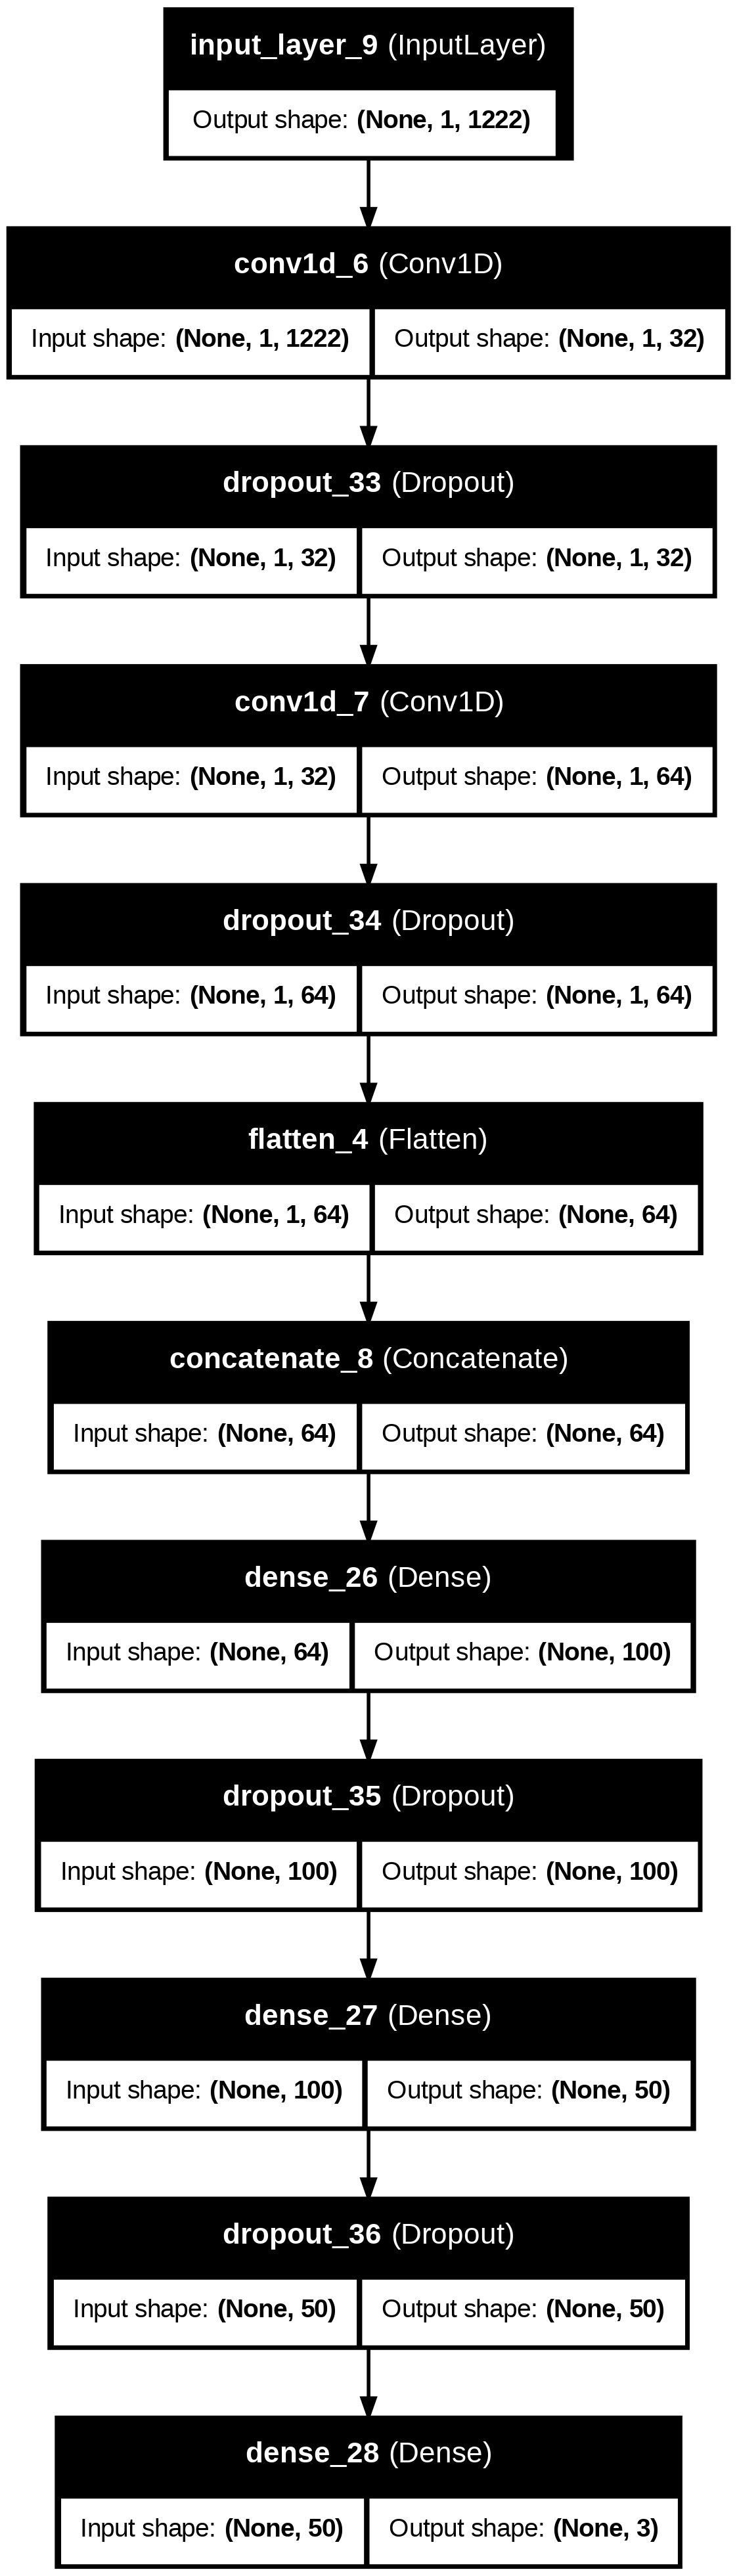

In [152]:
tf.keras.utils.plot_model(model_cnn, show_shapes=True, show_layer_names=True)

#### LSTM

In [94]:
def create_and_train_lstm_model(input_shapes, num_classes,
                                dropout_rate=0.5,X_train=None,y_train=None, kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                optimizer='adam', metrics=['accuracy'], validation_split=0.2, epochs=20, early_stopping = None):
    """
    Create and train an LSTM-based model.

    Parameters:
        input_shapes (list of tuple): A list of input shapes for each input tensor.
        num_classes (int): Number of output classes for classification.
        lstm_layers_config (list of dict): List of LSTM layer configurations,
            e.g., [{'units': 64, 'return_sequences': True}, ...].
        dense_layers_config (list of dict): List of dense layer configurations.
        dropout_rate (float): Dropout rate for regularization.
        kernel_regularizer (tf.keras.regularizers.Regularizer): Regularizer for the Dense layers.
        optimizer (str or tf.keras.optimizers.Optimizer): Optimizer for training.
        metrics (list): List of metrics to evaluate during training.
        validation_split (float): Fraction of training data to use as validation data.
        epochs (int): Number of training epochs.

    Returns:
        tf.keras.Model: The trained Keras model.
        tf.keras.callbacks.History: Training history object.
    """

    # Define dense layer configurations
    dense_layers_config = [
        {'units': 100, 'activation': 'relu'},
        {'units': 50, 'activation': 'relu'}
    ]


    # Define LSTM layer configurations for the LSTM model
    lstm_layers_config = [
        {'units': 64, 'return_sequences': True},
        {'units': 32, 'return_sequences': False}
    ]

    inputs = [tf.keras.Input(shape=shape) for shape in input_shapes]
    x = tf.keras.layers.concatenate(inputs, axis=-1)


    # Apply LSTM layers
    for layer_config in lstm_layers_config:
        x = tf.keras.layers.LSTM(
            units=layer_config['units'],
            return_sequences=layer_config.get('return_sequences', False),
            kernel_regularizer=kernel_regularizer
        )(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Dense layers
    for layer_config in dense_layers_config:
        x = tf.keras.layers.Dense(
            units=layer_config['units'],
            activation=layer_config.get('activation', 'relu'),
            kernel_regularizer=kernel_regularizer
        )(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)

    output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=output)

    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=metrics)
    model.summary()

    # Train the model if training data is provided
    if X_train and y_train is not None:
        history = model.fit(
            x=X_train, y=y_train,
            validation_split=validation_split,
            epochs=epochs,
            batch_size = 200
        )
        return model, history
    else:
        return model, None


In [95]:
# Define input shapes for the four inputs
input_shapes = [(1, X_train[0].shape[1])]

# Define dense layer configurations
dense_layers_config = [
    {'units': 100, 'activation': 'relu'},
    {'units': 50, 'activation': 'relu'}
]


# Define LSTM layer configurations for the LSTM model
lstm_layers_config = [
    {'units': 64, 'return_sequences': True},
    {'units': 32, 'return_sequences': False}
]

# Create the LSTM model
model_lstm, history_lstm = create_and_train_lstm_model(
    input_shapes=input_shapes,
    num_classes=num_classes,
    dropout_rate=0.2,
    optimizer='adam',
    metrics=['accuracy'],
    validation_split=0.2,
    X_train=[X_train],
    y_train=y_train,
    epochs=10,
    early_stopping=EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
)



Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 1, 1222)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ concatenate_9 (Concatenate)          │ (None, 1, 1222)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 1, 64)               │         329,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 100)                 │           3,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 3)                   │             153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 350,391 (1.34 MB)

 Trainable params: 350,391 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.3812 - loss: 1.7212 - val_accuracy: 0.6250 - val_loss: 1.6977
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4812 - loss: 1.6958 - val_accuracy: 0.6250 - val_loss: 1.6767
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.6562 - loss: 1.6666 - val_accuracy: 0.6750 - val_loss: 1.6540
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.7500 - loss: 1.6421 - val_accuracy: 0.7250 - val_loss: 1.6289
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8062 - loss: 1.6174 - val_accuracy: 0.7750 - val_loss: 1.6018
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8438 - loss: 1.5859 - val_accuracy: 0.7750 - val_loss: 1.5731
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8062 - loss: 1.5621 - val_accuracy: 0.8000 - val_loss: 1.5426
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8687 - loss: 1.5305 - val_accuracy: 0.8000 - val_loss: 1.5105

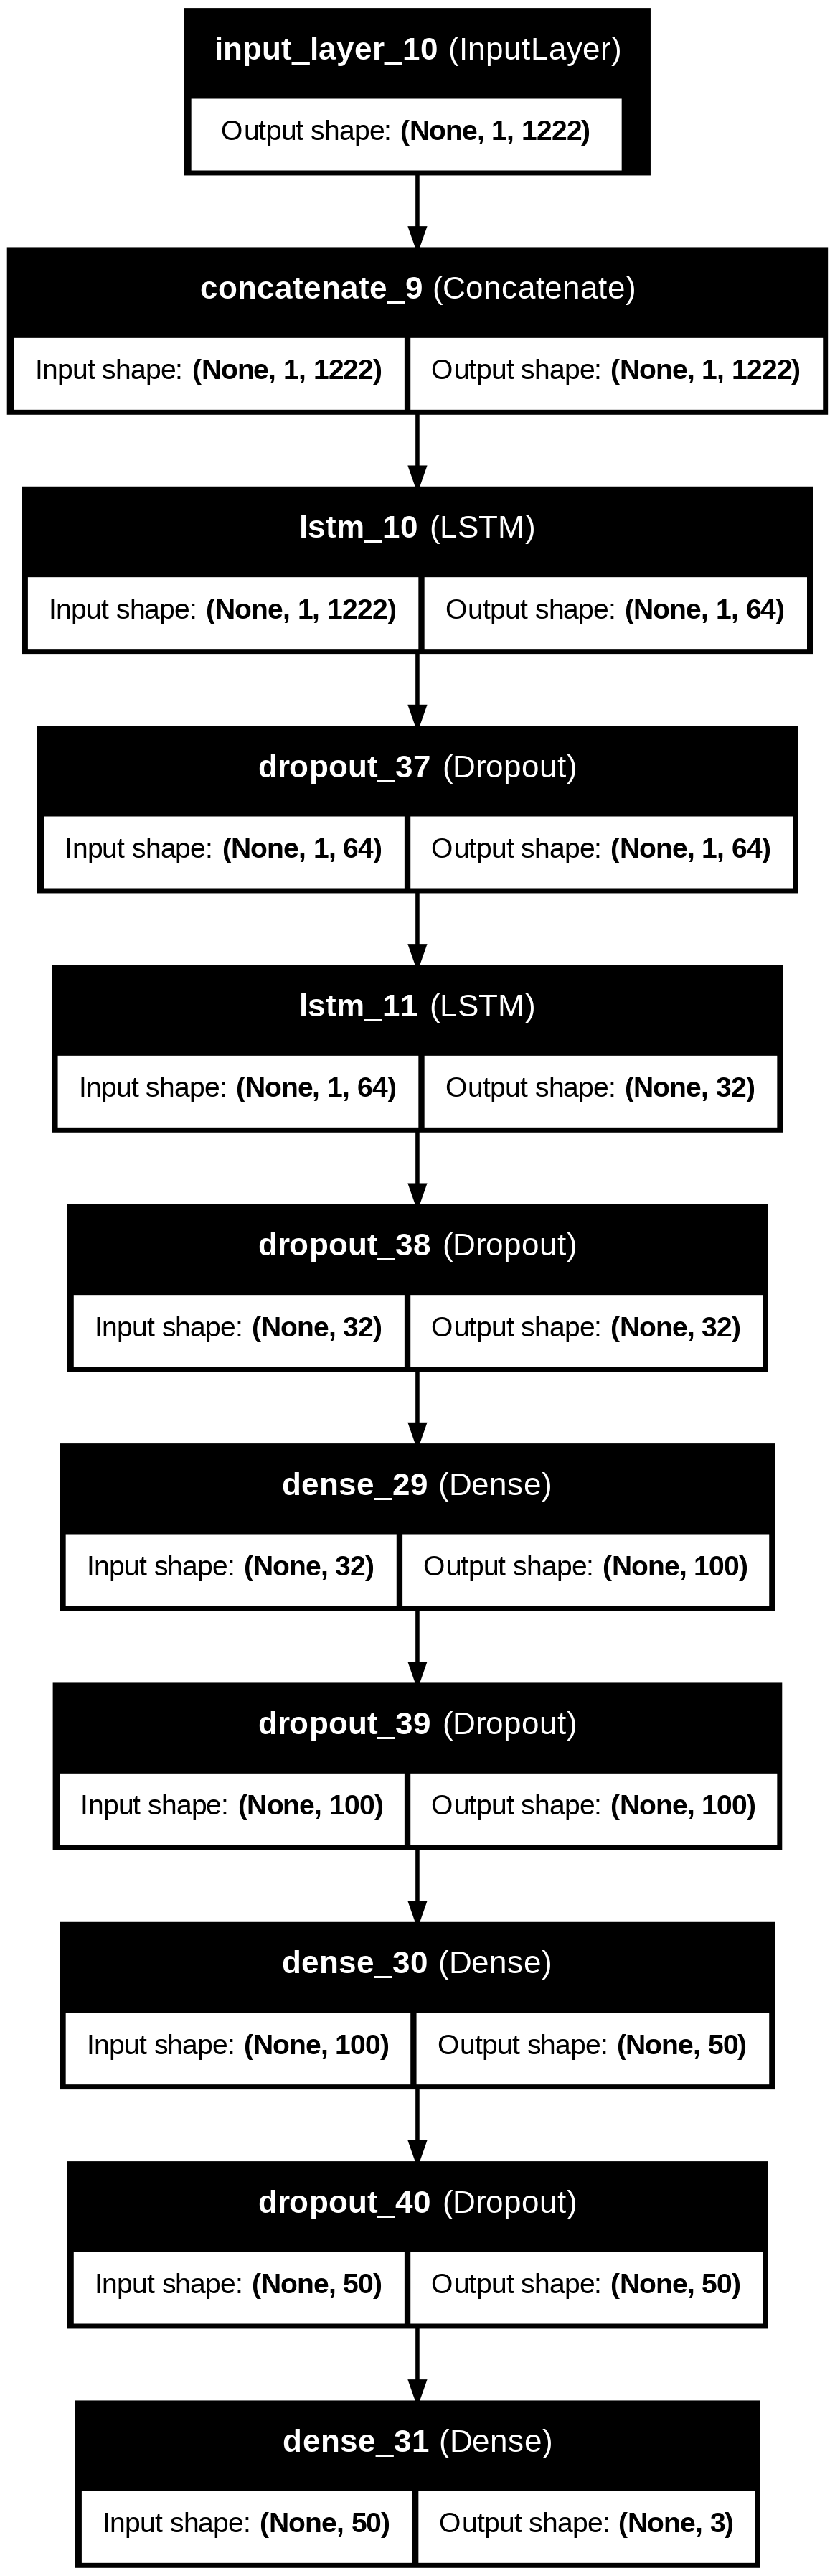

In [151]:
tf.keras.utils.plot_model(model_lstm, show_shapes=True, show_layer_names=True)

#### Evaluation

In [125]:
# Example models and datasets
models = [model_lstm, model_cnn]  # List of trained models
histories = [history_lstm, history_cnn] # List of training histories (optional)
models_name= ['LSTM', 'CNN'] # List of model names
# Initialize Benchmark class
benchmark = Benchmark(models, histories, models_name)

In [130]:

# Generate predictions
benchmark.predict_classes(X_test, y_test)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [131]:
# Print classification reports
benchmark.print_classification_reports()

Classification Report for Model_LSTM:
              precision    recall  f1-score  support
0                0.7600  1.000000  0.863636    19.00
1                1.0000  1.000000  1.000000    14.00
2                1.0000  0.647059  0.785714    17.00
accuracy         0.8800  0.880000  0.880000     0.88
macro avg        0.9200  0.882353  0.883117    50.00
weighted avg     0.9088  0.880000  0.875325    50.00


Classification Report for Model_CNN:
              precision    recall  f1-score  support
0              0.761905  0.842105  0.800000    19.00
1              0.736842  1.000000  0.848485    14.00
2              0.800000  0.470588  0.592593    17.00
accuracy       0.760000  0.760000  0.760000     0.76
macro avg      0.766249  0.770898  0.747026    50.00
weighted avg   0.767840  0.760000  0.743057    50.00




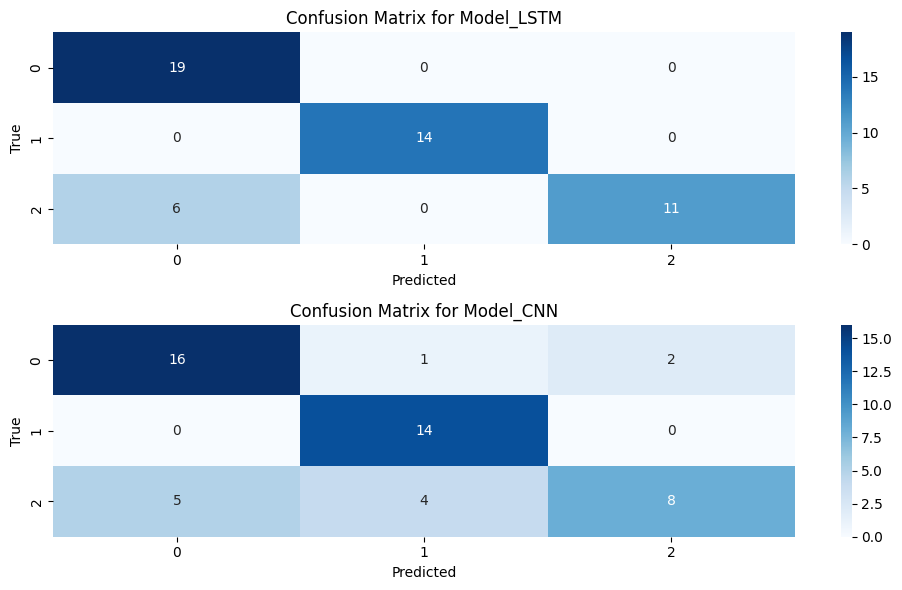

In [133]:

# Plot confusion matrices
benchmark.plot_confusion_matrices(y_test)


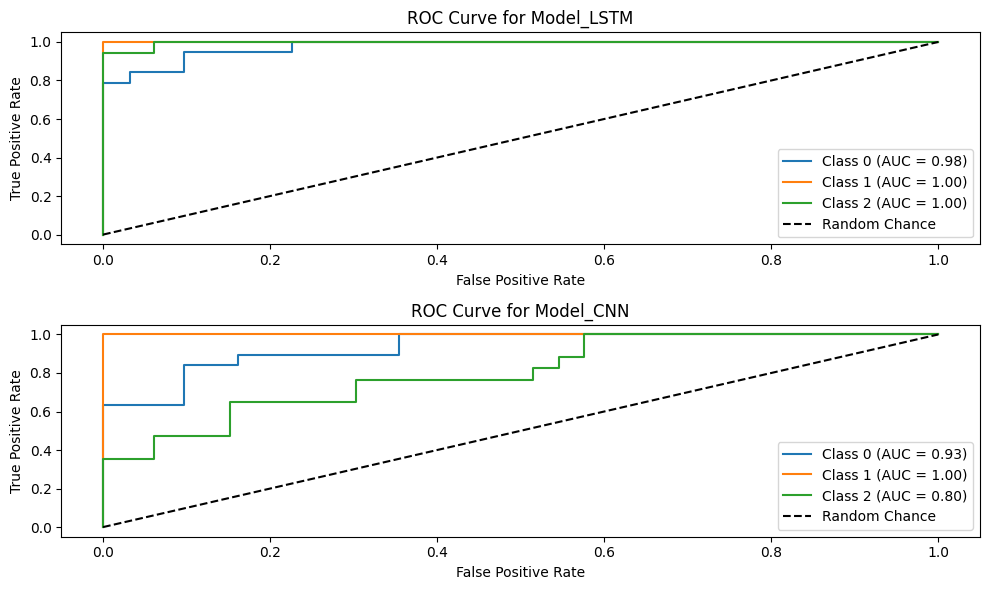

In [134]:

# Plot ROC curves
benchmark.plot_roc_curves(y_test)


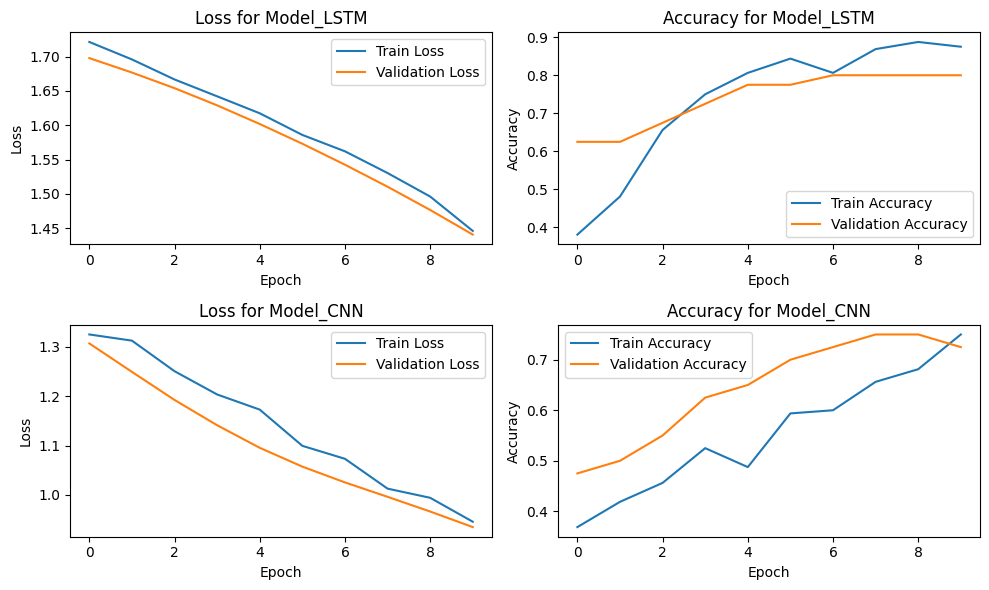

In [135]:

# Plot training histories
benchmark.plot_training_histories()


In [136]:
# Get metrics DataFrame
metrics_df = benchmark.get_metrics_dataframe()
metrics_df


,Model,Accuracy,Precision,Recall,F1-Score
0,Model_LSTM,0.88,0.90880,0.88,0.875325
1,Model_CNN,0.76,0.76784,0.76,0.743057


### With feature_type='spectograms'

In [107]:
def extract_features(data, feature_type='spectrogram', n_mfcc=13):
    """Extract features (MFCC or spectrogram) for all audio data."""
    features = []
    for file_name, y, sr in data:
        if feature_type == 'mfcc':
            feature = extract_mfcc(y, sr, n_mfcc=n_mfcc)
        elif feature_type == 'spectrogram':
            feature = extract_spectrogram(y, sr)
        features.append((file_name, feature))
    return features

# Extract features for train and test datasets
train_features = extract_features(train_processed, feature_type='spectrogram')

In [108]:
import numpy as np

# Normalize spectrogram features to the range [0, 1]
def normalize_spectrograms(features):
    normalized_features = []
    for file_name, feature in features:
        feature_normalized = (feature - np.min(feature)) / (np.max(feature) - np.min(feature))
        normalized_features.append((file_name, feature_normalized))
    return normalized_features

# Normalize the spectrogram data
train_features_normalized = normalize_spectrograms(train_features)


In [109]:
import cv2

# Resize all spectrograms to a consistent shape
def resize_spectrograms(features, target_shape=(128, 128)):
    resized_features = []
    for file_name, feature in features:
        feature_resized = cv2.resize(feature, target_shape, interpolation=cv2.INTER_AREA)
        resized_features.append((file_name, feature_resized))
    return resized_features

# Resize spectrograms to 128x128
train_features_resized = resize_spectrograms(train_features_normalized)


In [146]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Match features to labels
labels_dict = dict(zip(metadata['Filename'], metadata['Class']))
y_train = [labels_dict[file_name] for file_name, _ in train_features]

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

In [147]:
# Convert to NumPy arrays and add channel dimension
X = np.array([feature[1][:, :, np.newaxis] for feature in train_features_resized])  # Shape: (samples, 128, 128, 1)
y = np.array(y_train_encoded)  # Labels

print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (250, 128, 128, 1), y shape: (250,)


In [148]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (200, 128, 128, 1), y_train shape: (200,)
X_test shape: (50, 128, 128, 1), y_test shape: (50,)


In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y)), activation='softmax')  # Output layer with number of classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,347 (12.61 MB)

 Trainable params: 3,304,899 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.3692 - loss: 12.8355 - val_accuracy: 0.4600 - val_loss: 1.0465
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.5458 - loss: 1.6477 - val_accuracy: 0.3200 - val_loss: 5.7298
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6608 - loss: 0.9619 - val_accuracy: 0.3200 - val_loss: 14.5903
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6104 - loss: 0.8168 - val_accuracy: 0.3200 - val_loss: 22.3001
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6299 - loss: 0.6740 - val_accuracy: 0.3200 - val_loss: 28.4407
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6876 - loss: 0.5642 - val_accuracy: 0.3200 - val_loss: 33.3352
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6198 - loss: 0.5565 - val_accuracy: 0.3200 - val_loss: 36.9755
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6791 - loss: 0.5345 - val_accuracy: 0.3200 - val_loss: 40.2585
E

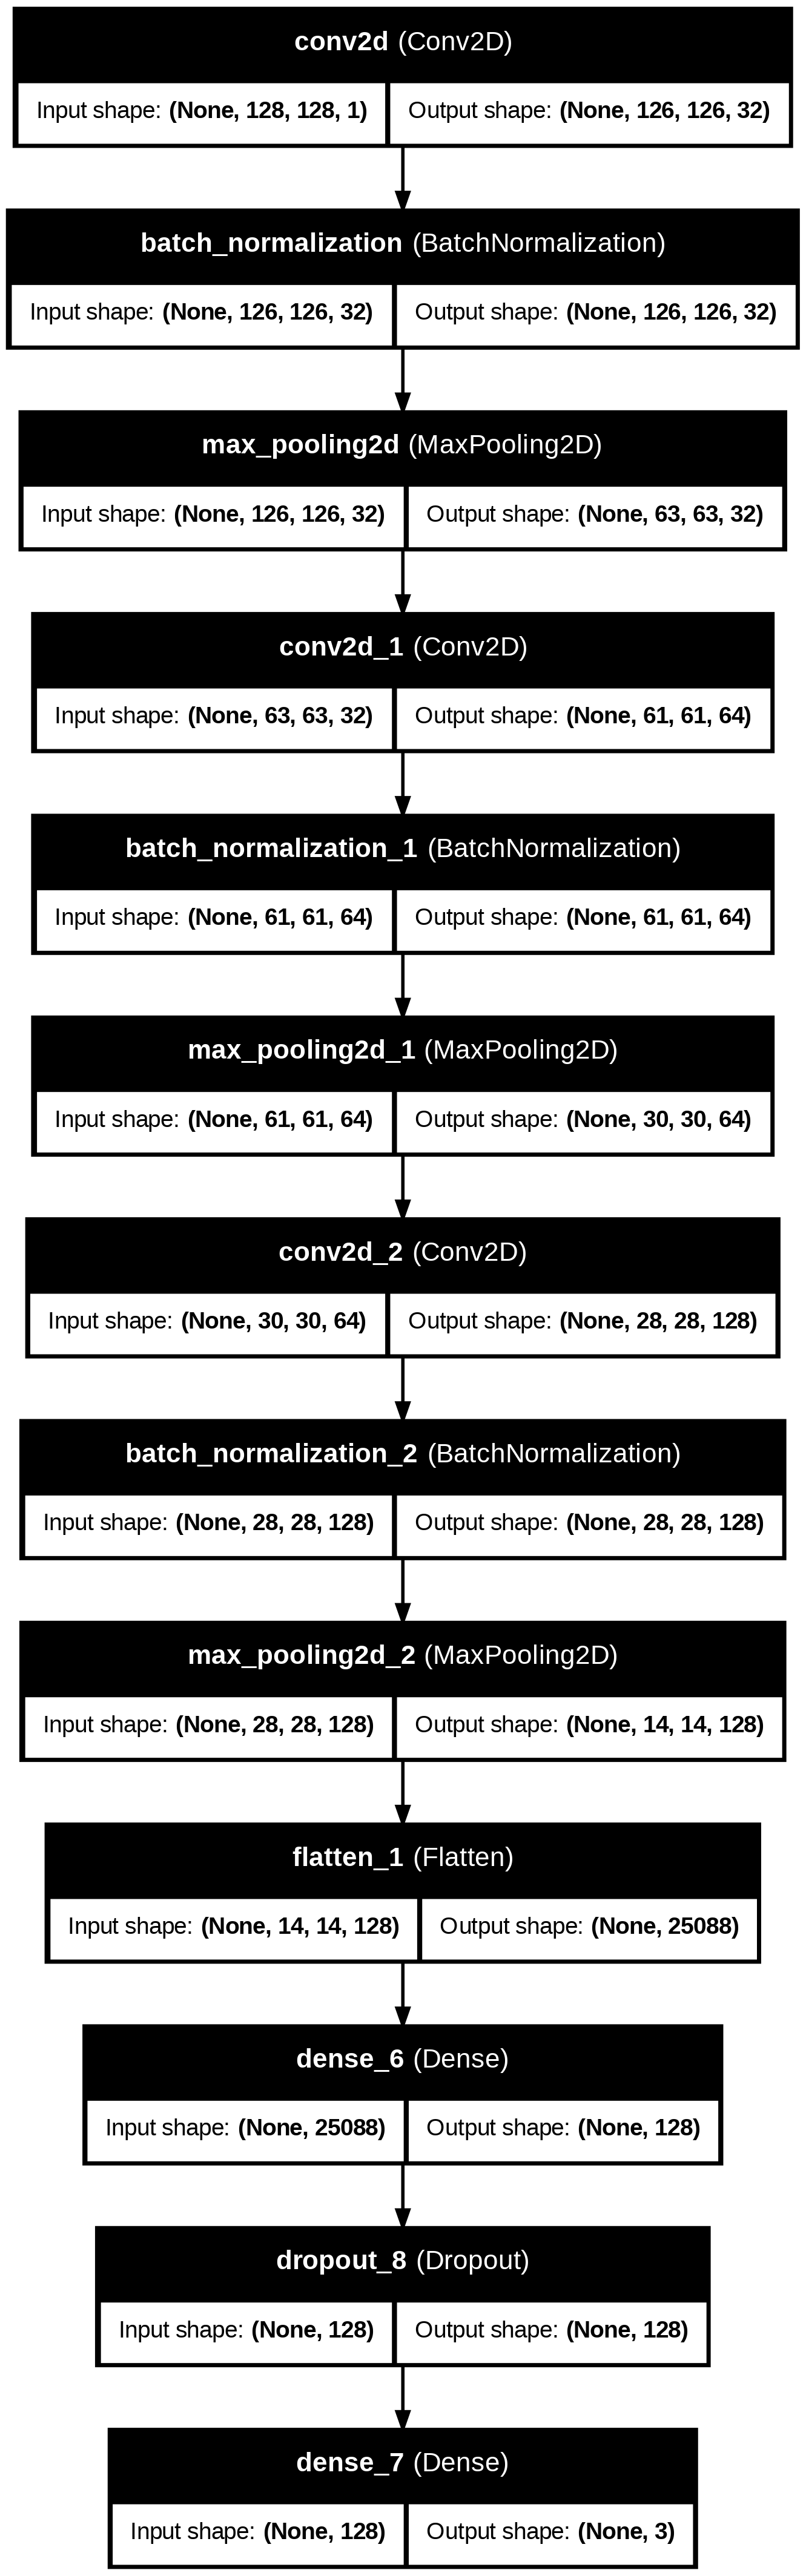

In [153]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

#### Evaluation

In [150]:
from sklearn.metrics import classification_report

print("Classification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.00      0.00      0.00        16
           2       0.32      1.00      0.48        16

    accuracy                           0.32        50
   macro avg       0.11      0.33      0.16        50
weighted avg       0.10      0.32      0.16        50



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Overfitting: The model is overfitting significantly, as shown by the increasing validation loss and stagnant validation accuracy. This could be due to insufficient regularization or a lack of diverse validation data.

## Zero shot prompting with audio to text llms

Zero-shot prompting refers to leveraging pre-trained audio-to-text large language models (LLMs) to perform tasks without requiring additional fine-tuning or task-specific training. These models can process audio inputs, transcribe them into text, and directly interpret or analyze the content based on the prompt, even for tasks they were not explicitly trained on.

#### Prepare the data

In [52]:
from datasets import Dataset, DatasetDict
import numpy as np


data = []
for (file_name, y, sr), label in zip(train_processed, y_train_encoded):
    data.append({
        'path': file_name,
        'audio': {'array': y.tolist(), 'path': file_name, 'sampling_rate': sr},  # Raw waveform
        'intent_class': label
    })

# Create a Dataset from the list of dictionaries
dataset = Dataset.from_list(data)

# Split into train and test sets (e.g., 80-20 split)
train_test_split = dataset.train_test_split(test_size=0.2, seed=42)

# Convert to DatasetDict
dataset_dict = DatasetDict({
    'train': train_test_split['train'],
    'test': train_test_split['test']
})

# Print a summary
print(dataset_dict)


DatasetDict({
    train: Dataset({
        features: ['path', 'audio', 'intent_class'],
        num_rows: 200
    })
    test: Dataset({
        features: ['path', 'audio', 'intent_class'],
        num_rows: 50
    })
})


In [55]:
from IPython.display import Audio
from datasets import load_dataset
from transformers import pipeline
# Extract all audio arrays from the 'test' subset
all_audio_arrays = [sample["audio"]["array"] for sample in dataset_dict["test"]]

# Print the total number of audio samples and the shape of the first sample
print(f"Number of audio samples: {len(all_audio_arrays)}")
print(f"Shape of the first audio array: {len(all_audio_arrays[0])}")  # Assuming 1D array

Number of audio samples: 50
Shape of the first audio array: 48000


In [ ]:
candidate_labels = ["Positive", "Negative", "Neutral"]

#### Prepare the model

In [ ]:
import numpy as np
from IPython.display import Audio
from datasets import load_dataset
from transformers import pipeline

audio_sample = next(iter(dataset_dict['test']))["audio"]["array"]
# Convert audio_sample to a NumPy array
audio_sample = np.array(audio_sample)

classifier = pipeline(
    task="zero-shot-audio-classification", model="laion/clap-htsat-unfused"
)
classifier(audio_sample, candidate_labels=candidate_labels)

[{'score': 0.7661595344543457, 'label': 'Positive'},
 {'score': 0.21496514976024628, 'label': 'Negative'},
 {'score': 0.018875276669859886, 'label': 'Neutral'}]

In [ ]:
results = []
for audio_sample in all_audio_arrays:
    # get mex score
    result = classifier(np.array(audio_sample), candidate_labels=candidate_labels)
    # Find the result with the maximum score
    max_result = max(result, key=lambda x: x['score'])
    results.append(max_result)


y_pred = results

In [ ]:
label_to_class = {
    "Negative": 0,
    "Neutral": 1,
    "Positive": 2
}

# Convert textual labels in y_pred to numerical labels
predicted_numerical_labels = [label_to_class[pred['label']] for pred in y_pred]


#### Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Evaluate accuracy
accuracy = accuracy_score(y_test, predicted_numerical_labels)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, predicted_numerical_labels, target_names=["Negative", "Neutral", "Positive"]))


Accuracy: 0.38
Classification Report:
              precision    recall  f1-score   support

    Negative       0.50      0.11      0.17        19
     Neutral       0.00      0.00      0.00        14
    Positive       0.37      1.00      0.54        17

    accuracy                           0.38        50
   macro avg       0.29      0.37      0.24        50
weighted avg       0.32      0.38      0.25        50



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model's Weaknesses: The model fails to correctly identify Neutral instances (both recall and precision are 0.00) and struggles with Negative instances, showing low recall and precision for those classes.

Zero-Shot Limitation: The results reflect the limitations of zero-shot learning. Since the model was not trained specifically for this task, it cannot effectively handle all classes, especially Neutral, without further fine-tuning or task-specific adjustments.

## Fine tune wav2vec2-base LLM

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

#### prepare the dataset


In [ ]:
from datasets import Dataset, DatasetDict
import numpy as np


data = []
for (file_name, y, sr), label in zip(train_processed, y_train_encoded):
    data.append({
        'path': file_name,
        'audio': {'array': y.tolist(), 'path': file_name, 'sampling_rate': sr},  # Raw waveform
        'intent_class': label
    })

# Create a Dataset from the list of dictionaries
dataset = Dataset.from_list(data)

# Split into train and test sets (e.g., 80-20 split)
train_test_split = dataset.train_test_split(test_size=0.2, seed=42)

# Convert to DatasetDict
dataset_dict = DatasetDict({
    'train': train_test_split['train'],
    'test': train_test_split['test']
})

# Print a summary
print(dataset_dict)


DatasetDict({
    train: Dataset({
        features: ['path', 'audio', 'intent_class'],
        num_rows: 200
    })
    test: Dataset({
        features: ['path', 'audio', 'intent_class'],
        num_rows: 50
    })
})


In [ ]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:306: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [ ]:
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays, sampling_rate=feature_extractor.sampling_rate, max_length=16000, truncation=True
    )
    return inputs
encoded_minds = dataset_dict.map(preprocess_function, remove_columns="audio", batched=True)
encoded_minds = encoded_minds.rename_column("intent_class", "label")

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")

In [ ]:
import numpy as np


def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=eval_pred.label_ids)


#### Prepare the model

In [ ]:
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer

num_labels = len(set(y_train))
label2id = {label: idx for idx, label in enumerate(set(y_train))}
id2label = {idx: label for label, idx in label2id.items()}

model = AutoModelForAudioClassification.from_pretrained(
    "facebook/wav2vec2-base", num_labels=num_labels, label2id=label2id, id2label=id2label
)

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:306: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Train the model

In [ ]:
training_args = TrainingArguments(
    output_dir="my_awesome_mind_model",  # Directory to save model checkpoints and logs during training.
    eval_strategy="epoch",  # Evaluate the model at the end of each epoch.
    save_strategy="epoch",  # Save the model checkpoint at the end of each epoch.
    learning_rate=3e-5,  # Initial learning rate for the optimizer. Controls the size of updates to the model's parameters.
    per_device_train_batch_size=32,  # Batch size for training on each device (GPU/CPU).
    gradient_accumulation_steps=4,  # Number of steps to accumulate gradients before performing a backward pass. Increases effective batch size.
    per_device_eval_batch_size=32,  # Batch size for evaluation on each device (GPU/CPU).
    num_train_epochs=10,  # Total number of epochs (complete passes through the dataset) to train the model.
    warmup_ratio=0.1,  # Fraction of the total training steps to linearly increase the learning rate from 0 to the set learning rate (used for warm-up).
    logging_steps=10,  # Number of steps between logging training progress (e.g., loss, learning rate).
    load_best_model_at_end=True,  # Automatically load the model checkpoint with the best evaluation metric at the end of training.
    metric_for_best_model="accuracy",  # Metric used to determine the best model checkpoint during evaluation.
    push_to_hub=False,  # Enable pushing the final model and configuration to the Hugging Face Model Hub.
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_minds["train"],
    eval_dataset=encoded_minds["test"],
    processing_class=feature_extractor,
    compute_metrics=compute_metrics,
)
# 91253b3e4ef889543ff99f298189c7974b144126
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
0,No log,1.101242,0.220000
1,No log,1.086931,0.660000
2,No log,1.075605,0.720000
4,No log,1.060173,0.620000
5,1.065700,1.055842,0.600000


TrainOutput(global_step=10, training_loss=1.065650749206543, metrics={'train_runtime': 1811.7505, 'train_samples_per_second': 1.104, 'train_steps_per_second': 0.006, 'total_flos': 1.053124248192e+16, 'train_loss': 1.065650749206543, 'epoch': 5.714285714285714})

The current fine-tuning run provides a baseline but indicates room for significant improvement. The drop in accuracy after the second epoch suggests that the model might be overfitting, under-trained, or influenced by issues related to the dataset. A key assumption could be that the dataset size is insufficient for effective training.

# Benchmark

In [142]:
results_df.rename(columns={'F1 Score': 'F1-Score'}, inplace=True)

In [145]:
merged_df = pd.concat([results_df, metrics_df], join='inner', axis=0)
merged_df

,Model,Accuracy,Precision,Recall,F1-Score
0,RandomForest,0.96,0.964211,0.96,0.960000
1,SVM,0.98,0.981111,0.98,0.980015
2,LogisticRegression,0.98,0.981111,0.98,0.980015
3,KNeighbors,0.96,0.964211,0.96,0.960000
0,Model_LSTM,0.88,0.908800,0.88,0.875325
1,Model_CNN,0.76,0.767840,0.76,0.743057


# Conclusion

**Machine learning Models Outperform Deep Learning:** The SVM and LogisticRegression models achieve the best performance across all metrics, closely followed by RandomForest and KNeighbors.

**Deep Learning Models:** LSTM performs moderately well but is still below traditional models. CNN significantly underperforms, indicating possible issues with the architecture or insufficient training for the dataset.

**Improvements and Verifications:**

For Machine learning models:
  * Scalability: Assess how these models handle larger datasets or high-dimensional data to confirm scalability.

For Deep Learning Models:

  * Hyperparameter Tuning:
      Optimize the learning rate, batch size, and number of layers/units for both LSTM and CNN.

  * Dataset Size and Augmentation:
      The dataset is small, we could apply data augmentation or more robust pre-trained models for transfer learning.

For the zero-shot and finetuned model:

  * Improve the quality of the data, choose a pre-trained model that aligns closely with the target task.,